In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [2]:
torch.cuda.set_device(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

device

device(type='cuda')

## General diffusion framework

In [3]:
class Diffusion(torch.nn.Module):
    def __init__(self, denoiser, loss=None, T=5):
        super().__init__()
        
        self.denoiser = denoiser
        self.loss = loss
        self.T = T
        
        if self.loss is None:
            self.loss = torch.nn.MSELoss()

    def apply_noise(self, x: torch.Tensor, z: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        return p * x + torch.sqrt(1.0 - p**2) * z

    def get_denoising_loss(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        
        t = torch.rand((batch_size,), device=device) * self.T
        p = torch.exp(-t)
        # p = torch.sqrt(1.0 - torch.rand((batch_size,), device=x.device)**2.0)
        
        z = torch.randn((x.shape[0], x.shape[1] // 2), device=x.device)
        
        # c == 0 -- marginal
        # c == 1 -- conditional 
        cond = int(np.random.random() > 0.5)
        half = x.shape[1] // 2    
        c = cond * torch.ones((batch_size,), device=device)

        x_noisy = self.apply_noise(x[:, :half], z, p)
        
        if cond == 0:
            z_pred = self.denoiser(torch.cat([x_noisy, torch.zeros_like(x_noisy).to(device)], dim=1), p, c)
        else:
            z_pred = self.denoiser(torch.cat([x_noisy, x[:, half:]], dim=1), p, c)

        return self.loss(z_pred, z)

    def sample(self, z: torch.Tensor, p_schedule: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # \overline{\alpha}_t = p_t^2
        # \overline{\alpha}_t = \prod_{s=1}^t \alpha_s
        # \alpha_s = 1 - \beta_s
        # \sigma_t^2 = \beta_t \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}

        overline_alpha = p_schedule**2
        alpha = overline_alpha[1::] / overline_alpha[:-1:]
        beta = 1.0 - alpha
        sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1:]) / (1.0 - overline_alpha[1::]))

        x = z

        for step in range(1, p_schedule.shape[0]):
            z_pred = self.denoiser(x, p_schedule[-step].repeat(x.shape[0]), c)
            
            x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
            x += sigma[-step] * torch.randn(x.shape, device=x.device)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.get_denoising_loss(x)

### MLP Denoiser

In [4]:
class ConditionalMLPDenoiser(torch.nn.Module):
    def __init__(self, data_dim: int, hidden_dim: int=256, add_dim: int=2):
        super().__init__()

        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(data_dim + add_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, data_dim // 2),
        )

    def forward(self, x: torch.Tensor, p: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        c = c.reshape((c.shape[0],) + (1,) * (len(x.shape) - 1))
        
        x_p = torch.cat([x, p, c], dim=-1)

        return self.MLP(x_p)

In [5]:
def draw_loss(losses, val_losses):
    plt.plot(losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.legend()
    plt.show()

In [6]:
def val(
    model,
    val_dataloader,
    val_losses
):
    with torch.no_grad():
        sum_loss = 0
        for batch in val_dataloader:
            if isinstance(batch, list):
                batch = batch[0]
            
            loss = model(batch.to(device))
            sum_loss += loss.item()
            
        val_losses.append(sum_loss / len(val_dataloader))

In [7]:
def train(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    n_epochs
):
    step = 0
    losses = []
    val_losses = []
    
    for epoch in trange(n_epochs):
        sum_loss = 0
        for batch in train_dataloader:
            if isinstance(batch, list):
                batch = batch[0]
            
            optimizer.zero_grad()    
            
            loss = model(batch.to(device))
            loss.backward()
            
            optimizer.step()
            
            sum_loss += loss.item()
            step += 1
        
        losses.append(sum_loss / len(train_dataloader))
        
        val(model, val_dataloader, val_losses)
        clear_output(wait=True)
        draw_loss(losses, val_losses)
        tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

# MI

In [94]:
def MI_multivariate_normal(cov):
    n_dim = cov.shape[1]
    n_half = n_dim // 2
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    det_cov_1 = torch.linalg.det(cov_1)
    det_cov_2 = torch.linalg.det(cov_2)
    det_cov = torch.linalg.det(cov)
    return torch.log(det_cov_1 * det_cov_2 / det_cov) / 2

In [95]:
def create_nd_correlated_data(n_samples, n_dim, r=0.7):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = torch.eye(n_dim)
    
    for i in range(n_dim):
        cov[i, n_dim - i - 1] = r

    mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = mvn.sample((n_samples,))
    
    A = dep_data[:, :n_half]
    B = dep_data[:, n_half:]
    
    indep_data = torch.cat([A, B[torch.randperm(n_samples)]], dim=1)
    
    return dep_data, indep_data, cov

In [96]:
def create_block_correlated_data(n_samples, n_dim, r=0.7):
    n_half = n_dim // 2
    
    mean = torch.zeros(n_half)
    cov_1 = torch.eye(n_half)
    
    for i in range(n_half):
        cov_1[i, n_half - i - 1] = r

    marginal = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_1)
    indep_data = torch.cat([marginal.sample((n_samples,)), marginal.sample((n_samples,))], dim=1)
    
    mean = torch.zeros(n_dim)
    cov = torch.block_diag(cov_1, cov_1)
    
    joint = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = joint.sample((n_samples,))
    
    return dep_data, indep_data, cov

In [97]:
def random_covariance_matrix(n):
    A = torch.randn(n, n)
    cov = A @ A.T
    d = torch.sqrt(torch.diag(cov))
    cov = cov / (d.unsqueeze(0) * d.unsqueeze(1))
    return cov

def create_randomly_correlated_normal_data(n_samples, n_dim):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = random_covariance_matrix(n_dim)

    joint = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = joint.sample((n_samples,))
    
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    
    marginal_1 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_1)
    marginal_2 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_2)
    
    A = marginal_1.sample((n_samples,))
    B = marginal_2.sample((n_samples,))
    
    indep_data = torch.cat([A, B], dim=1)
    
    return dep_data, indep_data, cov    

In [112]:
n_dim = 4
n_samples = 100_000

_, indep_data, cov = create_block_correlated_data(n_samples, n_dim)

cov[0][3] = 0.4
cov[3][0] = 0.4
cov[0][2] = 0.8
cov[2][0] = 0.8
cov[1][2] = 0.6
cov[2][1] = 0.6

joint = torch.distributions.MultivariateNormal(torch.zeros(n_dim), covariance_matrix=cov)
dep_data = joint.sample((n_samples,))

MI_multivariate_normal(cov), dep_data.shape, indep_data.shape

(tensor(0.9058), torch.Size([100000, 4]), torch.Size([100000, 4]))

In [129]:
dep_data, _, cov = create_randomly_correlated_normal_data(n_samples, n_dim)
MI_multivariate_normal(cov), cov

(tensor(2.8115),
 tensor([[ 1.0000, -0.1187,  0.7429,  0.0362],
         [-0.1187,  1.0000,  0.1787,  0.9731],
         [ 0.7429,  0.1787,  1.0000,  0.2035],
         [ 0.0362,  0.9731,  0.2035,  1.0000]]))

In [130]:
# train val split 
dep_data, dep_data_val = dep_data[:int(n_samples * 0.9)], dep_data[int(n_samples * 0.9):]

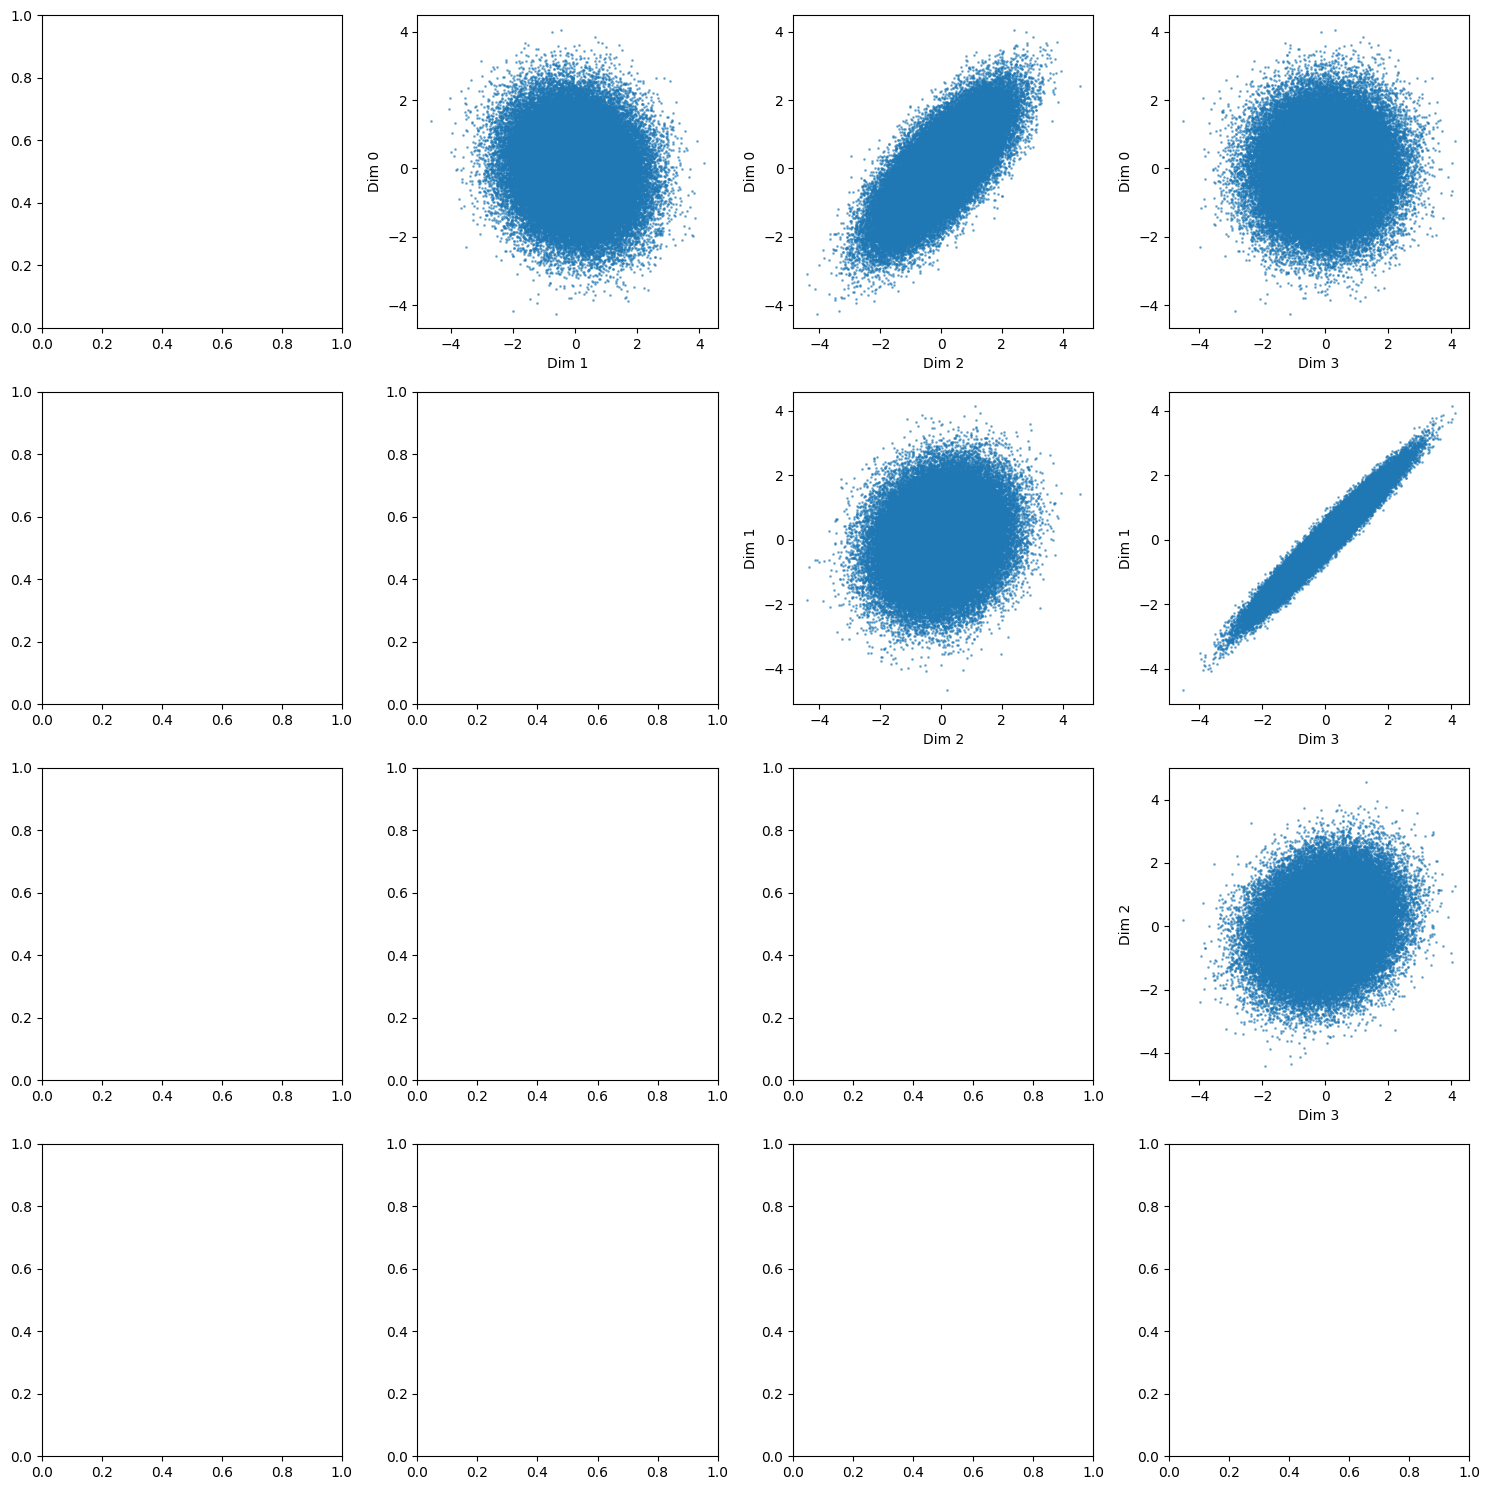

In [131]:
n_dims = dep_data.shape[1]
fig, axes = plt.subplots(n_dims, n_dims, figsize=(15, 15))

for i in range(n_dims):
    for j in range(i + 1, n_dims):
        axes[i, j].scatter(dep_data[:, j], dep_data[:, i], s=1, alpha=0.5)
        axes[i, j].set_xlabel(f'Dim {j}')
        axes[i, j].set_ylabel(f'Dim {i}')

plt.tight_layout()
plt.show()

In [132]:
dep_train_dataset = TensorDataset(dep_data)
dep_val_dataset = TensorDataset(dep_data_val)

dep_train_dataloader = DataLoader(dep_train_dataset, batch_size=1024, shuffle=True)
dep_val_dataloader = DataLoader(dep_val_dataset, batch_size=1024, shuffle=True)

In [133]:
model = Diffusion(ConditionalMLPDenoiser(data_dim=n_dim, add_dim=2)).to(device)

In [134]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

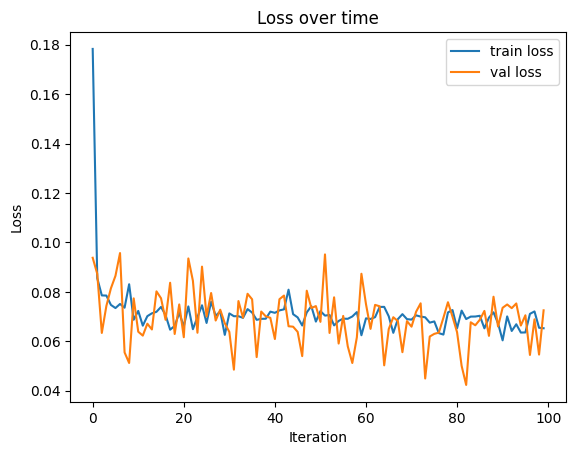

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Epoch [100/100], Step [8800/88], Loss: 0.0934


In [135]:
train(model, optimizer, dep_train_dataloader, dep_val_dataloader, 100)

In [136]:
def score_func(model, X_t, t, c):
    p = torch.exp(-t)
    X_t = X_t.to(device)
    p = p.to(device)
    c = c.to(device)
    
    z = -model.denoiser(X_t, p, c).detach() / torch.sqrt(1 - p ** 2)
    return z

In [142]:
def estimate_MI_steps(X, dt=0.01, T=5, batch_size=100_000):
    
    t_range = np.arange(dt / 2, T, step=dt)
    average_errors = []
    
    for i in trange(len(t_range) - 1):
        t, dt = torch.tensor(t_range[i]), t_range[i + 1] - t_range[i]
        
        squared_error = 0
        
        idx = np.random.randint(0, len(dep_data), batch_size)
        
        AB = dep_data[idx]
        A = AB[:, :n_dim//2]
        B = AB[:, n_dim//2:]
        
        z = torch.randn(size=(1, A.shape[1]))
        X_t = torch.exp(-t) * A + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        t = t * torch.ones((batch_size, 1))
        
        score_A = score_func(model, torch.cat([X_t, torch.zeros_like(X_t)], dim=1), t, torch.zeros(batch_size)).cpu()
        score_A_B = score_func(model, torch.cat([X_t, B], dim=1), t, torch.ones(batch_size)).cpu()

        squared_error += torch.square(score_A - score_A_B).sum()
        
        err = squared_error / batch_size
        average_errors.append(err.item())
        
    return average_errors, np.sum(average_errors) * dt

100%|██████████| 4999/4999 [01:35<00:00, 52.26it/s]


2.929441906720057


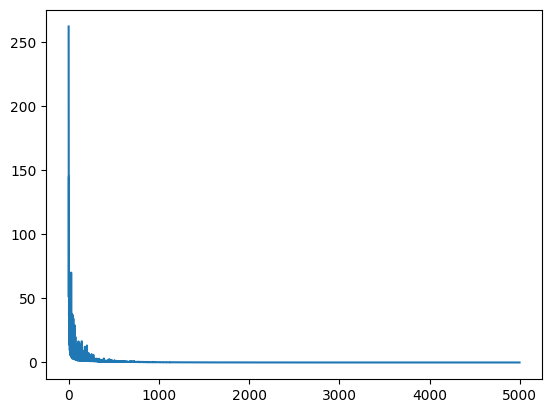

In [145]:
average_errors, MI = estimate_MI_steps(dep_data, batch_size=100_000, dt=0.001)
print(MI)
plt.plot(average_errors)
plt.show()